# Hidden Field Serialization
This notebook benchmarks the performance of different methods for hiding fields in a model.
The goal is to reduce the overhead of fast path serialization which is when the hidden fields are included in the model dump.
This is because most hot-loop operations on context objects require hidden and non-hidden fields (e.x like uploading to a database). Hidden fields are usually excluded during things like prompting, or printing which is not really a hot loop.

## Define Pydantic BaseModels For Benchmarking

### Regular Model
Uses Field(exclude=True) to hide models.
### HiddenModel
Hides fields with modaic's `Field(hidden=True)`
Hidden fields are marked during serialization and can be excluded from the model dump. If include_hidden is set to False, the hidden fields are excluded from the model dump.
### HiddenModelPC
Hides fields with modaic's `Field(hidden=True)`
Hidden fields are precomputed during class definition, then excluded during serialization.


In [ ]:
from typing import Any

from pydantic import BaseModel, Field, SerializationInfo, SerializerFunctionWrapHandler, model_serializer


class InnerRegularModel(BaseModel):
    employee_name: str
    password: str


class InnerExcludedModel(BaseModel):
    employee_name: str
    password: str = Field(exclude=True)


class RegularModel(BaseModel):
    name: str
    age: int
    inner_context: InnerRegularModel

class RegularExcludedModel(BaseModel):
    name: str
    age: int
    inner_context: InnerExcludedModel
    

class HiddenModel(BaseModel):
    @model_serializer(mode="wrap")
    def ser_model(self, handler: SerializerFunctionWrapHandler, info: SerializationInfo) -> dict[str, Any]:
        dump = handler(self)
        if info.context is None or not info.context.get("include_hidden"):
            for name, field in self.__class__.model_fields.items():
                if (extra := getattr(field, "json_schema_extra", None)) and extra.get("hidden"):
                    dump.pop(name)
        return dump
    
    def model_dump(self, **kwargs) -> dict[str, Any]:
        include_hidden = kwargs.pop("include_hidden", False)
        if include_hidden:
            return super().model_dump(**kwargs, context={"include_hidden": True})
        else:
            return super().model_dump(**kwargs)


class InnerHiddenModel(HiddenModel):
    employee_name: str
    password: str = Field(hidden=True)


class OuterHiddenModel(HiddenModel):
    name: str
    age: int
    inner_context: InnerHiddenModel


class HiddenModelPC(BaseModel):
    @model_serializer(mode="wrap")
    def ser_model(self, handler: SerializerFunctionWrapHandler, info: SerializationInfo) -> dict[str, Any]:
        dump = handler(self)
        if info.context is None or not info.context.get("include_hidden"):
            for field in self.__class__.hidden:
                dump.pop(field)
        return dump

    @classmethod
    def __pydantic_init_subclass__(cls, **kwargs):
        cls.hidden = set()
        for _, field in cls.model_fields.items():
            if (extra := getattr(field, "json_schema_extra", None)) and extra.get("hidden"):
                cls.hidden.add(field)
    
    def model_dump(self, **kwargs) -> dict[str, Any]:
        include_hidden = kwargs.pop("include_hidden", False)
        if include_hidden:
            return super().model_dump(**kwargs, context={"include_hidden": True})
        else:
            return super().model_dump(**kwargs)


class InnerHiddenModelPC(HiddenModel):
    employee_name: str
    password: str = Field(hidden=True)


class OuterHiddenModelPC(HiddenModel):
    name: str
    age: int
    inner_context: InnerHiddenModelPC



## Define Benchmark Functions

In [ ]:
import time
from typing import Type, Callable

import matplotlib.pyplot as plt


def _default_kwargs(outer_cls: Type[BaseModel], inner_cls: Type[BaseModel]):
    return dict(
        name="John",
        age=30,
        inner_context=inner_cls(employee_name="John", password="this should be hidden"),
    )

def _bench_regular_progress(N: int, include_hidden: bool, step: int, make_instance_kwargs: Callable=None):
    if make_instance_kwargs is None:
        make_instance_kwargs = _default_kwargs
    
    if include_hidden:
        outer_cls = RegularModel
        inner_cls = InnerRegularModel
    else:
        outer_cls = RegularExcludedModel
        inner_cls = InnerExcludedModel
    
    xs, ys = [], []
    
    start = time.perf_counter()
    for i in range(1, N + 1):
        instance = outer_cls(**make_instance_kwargs(outer_cls, inner_cls))
        instance.model_dump()
        if i % step == 0 or i == N:
            xs.append(i)
            ys.append(time.perf_counter() - start)

    return xs, ys
    
def _bench_progress(outer_cls, inner_cls, N, include_hidden, step, make_instance_kwargs=None):
    """Run one benchmark up to N, recording elapsed time every `step` iterations."""
    if make_instance_kwargs is None:
        make_instance_kwargs = _default_kwargs

    xs, ys = [], []

    start = time.perf_counter()
    for i in range(1, N + 1):
        instance = outer_cls(**make_instance_kwargs(outer_cls, inner_cls))
        instance.model_dump(include_hidden=include_hidden)
        if i % step == 0 or i == N:
            xs.append(i)
            ys.append(time.perf_counter() - start)

    return xs, ys

def run_benchmarks(
    pairs,          # [(OuterClass, InnerClass), ...]
    *,
    N=100_000,
    step=5_000,
    warmup_iters=10_000,
    make_instance_kwargs=None,
):
    # global warmup
    for _ in range(warmup_iters):
        pass

    # quick sanity check
    for outer_cls, inner_cls in pairs:
        inst = outer_cls(**(make_instance_kwargs(outer_cls, inner_cls)
                            if make_instance_kwargs else _default_kwargs(outer_cls, inner_cls)))
        print(f"{outer_cls.__name__} - include_hidden=False")
        print(inst.model_dump())
        print(f"{outer_cls.__name__} - include_hidden=True")
        print(inst.model_dump(include_hidden = True))
    
    exclude_instance = RegularExcludedModel(
        **make_instance_kwargs(RegularExcludedModel, InnerExcludedModel)
        if make_instance_kwargs
        else _default_kwargs(RegularExcludedModel, InnerExcludedModel)
    )
    print("RegularModel - include_hidden=False")
    print(exclude_instance.model_dump())
    include_instance = RegularModel(**make_instance_kwargs(RegularModel, InnerRegularModel) if make_instance_kwargs else _default_kwargs(RegularModel, InnerRegularModel))
    print("RegularModel - include_hidden=True")
    print(include_instance.model_dump())

    # hide: no context
    fig1 = plt.figure()
    ax1 = fig1.gca()
    for outer_cls, inner_cls in pairs:
        xs, ys = _bench_progress(outer_cls, inner_cls, N, False, step, make_instance_kwargs)
        ax1.plot(xs, ys, label=outer_cls.__name__)
    xs, ys = _bench_regular_progress(N, False, step, make_instance_kwargs)
    ax1.plot(xs, ys, label="RegularModel")
    ax1.set_xlabel("Number of instances")
    ax1.set_ylabel("Total seconds")
    ax1.set_title("Total time vs number of dumps - hide (include_hidden=False)")
    ax1.legend()
    fig1.tight_layout()

    # show: context={"include_hidden": True}
    fig2 = plt.figure()
    ax2 = fig2.gca()
    for outer_cls, inner_cls in pairs:
        xs, ys = _bench_progress(outer_cls, inner_cls, N, True, step, make_instance_kwargs)
        ax2.plot(xs, ys, label=outer_cls.__name__)
    xs, ys = _bench_regular_progress(N, True, step, make_instance_kwargs)
    ax2.plot(xs, ys, label="RegularModel")
    ax2.set_xlabel("Number of instances")
    ax2.set_ylabel("Total seconds")
    ax2.set_title("Total time vs number of dumps - show (include_hidden=True)")
    ax2.legend()
    fig2.tight_layout()

    plt.show()



## Run Benchmarks

### Naive Approach (only use @model_serializer)

OuterHiddenModel - include_hidden=False
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John'}}
OuterHiddenModel - include_hidden=True
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John', 'password': 'this should be hidden'}}
OuterHiddenModelPC - include_hidden=False
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John'}}
OuterHiddenModelPC - include_hidden=True
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John', 'password': 'this should be hidden'}}
RegularModel - include_hidden=False
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John'}}
RegularModel - include_hidden=True
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John', 'password': 'this should be hidden'}}


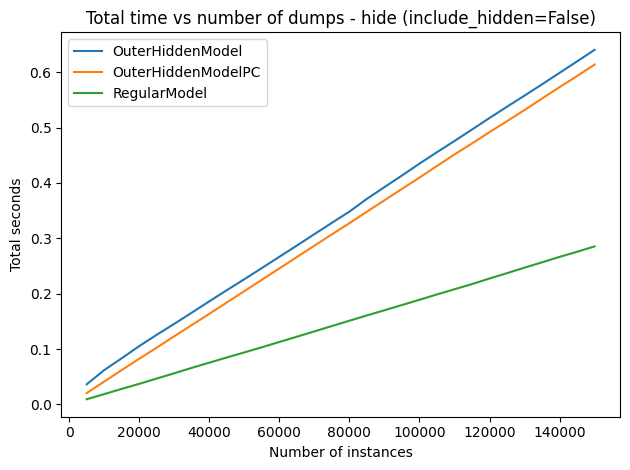

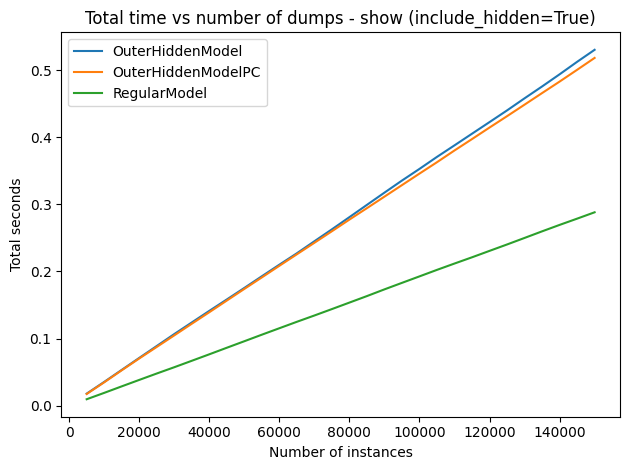

In [58]:
pairs = [
    (OuterHiddenModel, InnerHiddenModel),
    (OuterHiddenModelPC, InnerHiddenModelPC),
]

run_benchmarks(pairs, N=150_000)


### Advanced Approach 

As you can see, the RegularModel is the fastest, because it uses pydantic's default serialization.
Precomputing also doesn't help that much.
In the next step we'll try to make `HiddenModel` serialize faster by skipping over @model_serializer when include_hidden is True.

In [59]:
import copy

from pydantic_core import SchemaSerializer


def _get_unhidden_serializer(cls: type[BaseModel]) -> SchemaSerializer:
    """
    Creates a new serializer from cls.__pydantic_core_schema__ with the hidden fields included.
    This is nescesarry to recursively dump hidden Context objects with hidden fields inside of other context objects.
    """
    core = copy.deepcopy(cls.__pydantic_core_schema__)

    def walk(node: dict | list):
        if isinstance(node, dict):
            if node.get("type") == "model" and node.get("serialization", {}).get("function", None) is HiddenModelFast.hidden_serializer:
                del node["serialization"]
            for v in node.values():
                walk(v)
        elif isinstance(node, list):
            for v in node:
                walk(v)

    walk(core)
    return SchemaSerializer(core)



class HiddenModelFast(BaseModel):
    @model_serializer(mode="wrap")
    def hidden_serializer(self, handler: SerializerFunctionWrapHandler, info: SerializationInfo) -> dict[str, Any]:
        dump = handler(self)
        if info.context is None or not info.context.get("include_hidden"):
            for name, field in self.__class__.model_fields.items():
                if (extra := getattr(field, "json_schema_extra", None)) and extra.get("hidden"):
                    dump.pop(name)
        return dump
    
    @classmethod
    def __pydantic_init_subclass__(cls, **kwargs):
        cls.__modaic_serializer__ = _get_unhidden_serializer(cls)
        
    
    def model_dump(self, **kwargs):
        include_hidden = kwargs.pop("include_hidden", False)
        if include_hidden:
            return self.__modaic_serializer__.to_python(self, **kwargs)
        else:
            return super().model_dump(**kwargs)
    


class InnerHiddenModelFast(HiddenModelFast):
    employee_name: str
    password: str = Field(hidden=True)


class OuterHiddenModelFast(HiddenModelFast):
    name: str
    age: int
    inner_context: InnerHiddenModelFast


x = OuterHiddenModelFast(name="John", age=30, inner_context=InnerHiddenModelFast(employee_name="John", password="this should be hidden"))
print("Hidden")
print(x.model_dump())

print("Unhidden")
print(x.__modaic_serializer__.to_python(x))


Hidden
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John'}}
Unhidden
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John', 'password': 'this should be hidden'}}


#### Results

OuterHiddenModelPC - include_hidden=False
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John'}}
OuterHiddenModelPC - include_hidden=True
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John', 'password': 'this should be hidden'}}
OuterHiddenModelFast - include_hidden=False
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John'}}
OuterHiddenModelFast - include_hidden=True
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John', 'password': 'this should be hidden'}}
RegularModel - include_hidden=False
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John'}}
RegularModel - include_hidden=True
{'name': 'John', 'age': 30, 'inner_context': {'employee_name': 'John', 'password': 'this should be hidden'}}


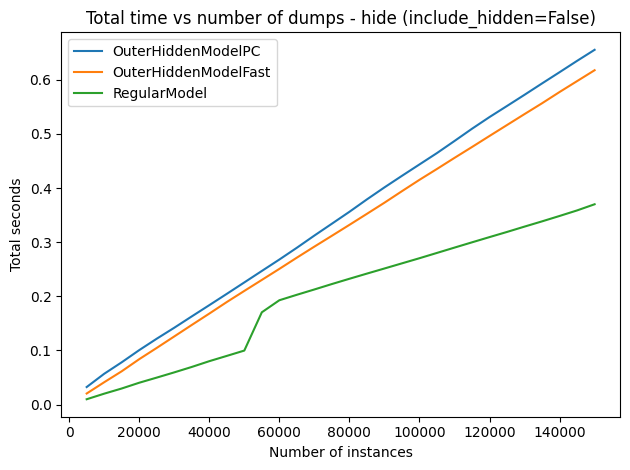

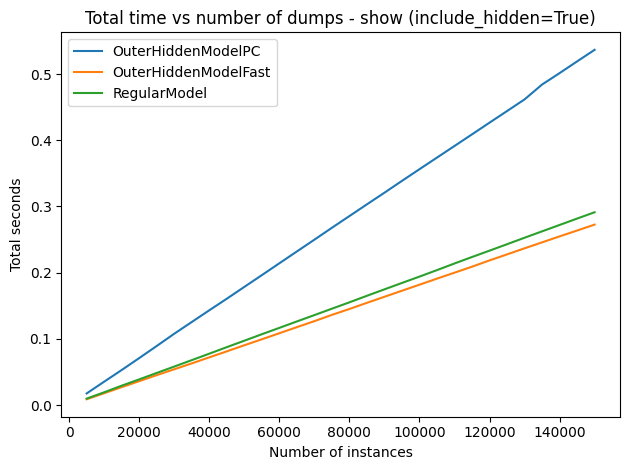

In [61]:
pairs = [
    (OuterHiddenModelPC, InnerHiddenModelPC),
    (OuterHiddenModelFast, InnerHiddenModelFast),
]

run_benchmarks(pairs, N=150_000)

It works!!!!